<a href="https://colab.research.google.com/github/merajsiddieque/ML-Lab/blob/main/ML_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Datasets/Housing.csv')

In [ ]:
df.columns


Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
X = df.drop("price", axis=1)


In [ ]:
# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [ ]:
print(X)

     area  bedrooms  bathrooms  stories  parking  mainroad_yes  guestroom_yes  \
0    7420         4          2        3        2          True          False   
1    8960         4          4        4        3          True          False   
2    9960         3          2        2        2          True          False   
3    7500         4          2        2        3          True          False   
4    7420         4          1        2        2          True           True   
..    ...       ...        ...      ...      ...           ...            ...   
540  3000         2          1        1        2          True          False   
541  2400         3          1        1        0         False          False   
542  3620         2          1        1        0          True          False   
543  2910         3          1        1        0         False          False   
544  3850         3          1        2        0          True          False   

     basement_yes  hotwater

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Mean-center
mu = np.mean(X_scaled, axis=0)
A = X_scaled - mu

In [ ]:
# Covariance matrix
C = np.dot(A.T, A)

In [ ]:
# Eigen decomposition
eigvals, eigvecs = np.linalg.eigh(C)

In [ ]:
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

In [ ]:
# Function to compute reconstruction error for top n eigenvectors
def reconstruction_error(A, eigvecs, n):
    # take top n eigenvectors
    E = eigvecs[:, :n]

    errors = []
    for i in range(A.shape[0]):
        ai = A[i, :]
        # projection on eigenspace
        w = np.dot(E.T, ai)
        # linear combination
        li = np.dot(E, w)
        # reconstruction
        ri = li + mu
        # error (squared norm)
        err = np.linalg.norm((ai + mu) - ri) ** 2
        errors.append(err)

    return np.mean(errors)

In [ ]:
# Experiment with different n
n_values = [1, 2, 3, 5, 7, 10, 15]
errors = {n: reconstruction_error(A, eigvecs, n) for n in n_values}

In [ ]:
print("Reconstruction Errors for Housing.csv:")
for n, err in errors.items():
    print(f"n={n}: {err:.4f}")

Reconstruction Errors for Housing.csv:
n=1: 10.5303
n=2: 8.9575
n=3: 7.4574
n=5: 5.0970
n=7: 3.3809
n=10: 1.3663
n=15: 0.0000


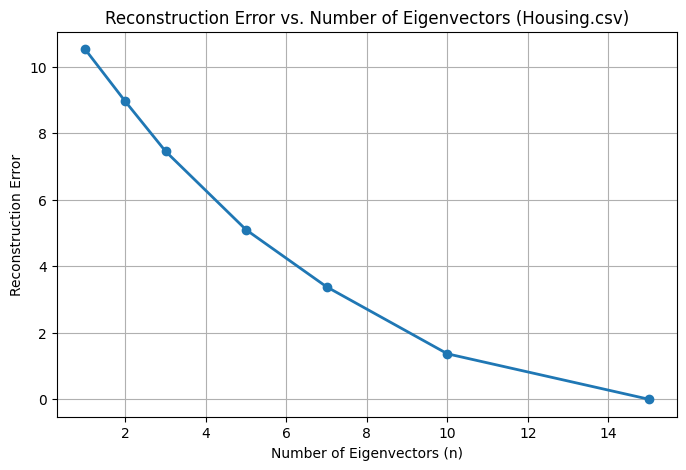

In [ ]:
import matplotlib.pyplot as plt

# Plot reconstruction error graph
plt.figure(figsize=(8,5))
plt.plot(list(errors.keys()), list(errors.values()), marker='o', linestyle='-', linewidth=2)
plt.xlabel("Number of Eigenvectors (n)")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs. Number of Eigenvectors (Housing.csv)")
plt.grid(True)
plt.show()


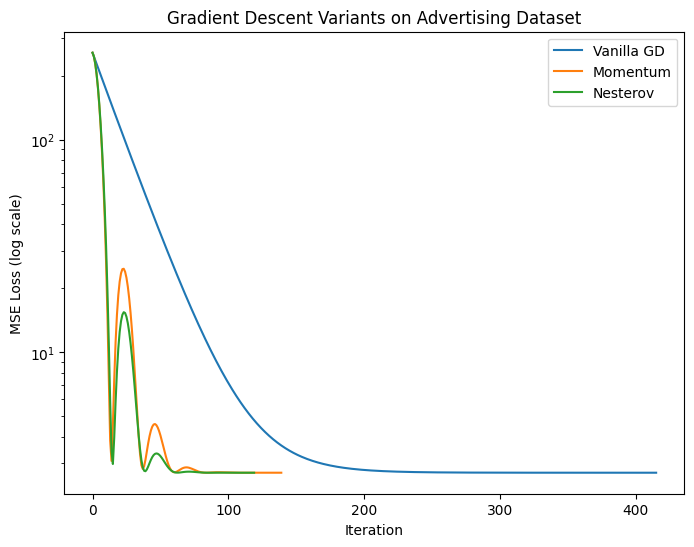

Vanilla GD:   416 iterations, Final Loss = 2.706037
Momentum GD:  140 iterations, Final Loss = 2.706113
Nesterov GD:  120 iterations, Final Loss = 2.706085


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/Datasets/advertising.csv").dropna()

# Separate X, y
y = df["Sales"].values.reshape(-1, 1)
X = df.drop("Sales", axis=1)

# Encode categorical if any
X = pd.get_dummies(X, drop_first=True)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Add bias column
X = np.hstack([X, np.ones((X.shape[0], 1))])

# 2. Linear Regression Loss + Gradient (MSE)
def mse_loss(w, X, y):
    n = len(y)
    preds = X @ w
    return ((preds - y)**2).mean()

def mse_grad(w, X, y):
    n = len(y)
    preds = X @ w
    return (2/n) * (X.T @ (preds - y))

# 3. Optimizers
def make_vanilla(eta):
    def step(w, grad, state):
        return w - eta * grad, state
    return step

def make_momentum(eta, gamma):
    def step(w, grad, state):
        if state is None:
            v = np.zeros_like(w)
        else:
            v = state
        v_new = gamma * v + eta * grad
        return w - v_new, v_new
    return step

def run_optimizer(grad_fn, loss_fn, w0, optimizer, X, y, max_iters=1000, tol=1e-6):
    w = w0.copy()
    state = None
    history = [loss_fn(w, X, y)]
    prev_loss = history[-1]

    for t in range(max_iters):
        g = grad_fn(w, X, y)
        w, state = optimizer(w, g, state)
        loss = loss_fn(w, X, y)
        history.append(loss)
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss
    return history

def run_nesterov(w0, eta, gamma, X, y, max_iters=1000, tol=1e-6):
    w = w0.copy()
    v = np.zeros_like(w)
    history = [mse_loss(w, X, y)]
    prev_loss = history[-1]

    for t in range(max_iters):
        lookahead = w - gamma * v
        g = mse_grad(lookahead, X, y)
        v = gamma * v + eta * g
        w = w - v
        loss = mse_loss(w, X, y)
        history.append(loss)
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss
    return history

# 4. Run Experiments
w0 = np.random.randn(X.shape[1], 1) * 0.01

eta_van, eta_mom, gamma = 0.01, 0.01, 0.9

hist_van = run_optimizer(mse_grad, mse_loss, w0, make_vanilla(eta_van), X, y)
hist_mom = run_optimizer(mse_grad, mse_loss, w0, make_momentum(eta_mom, gamma), X, y)
hist_nag = run_nesterov(w0, eta=eta_mom, gamma=gamma, X=X, y=y)

# 5. Plot Results
plt.figure(figsize=(8,6))
plt.plot(hist_van, label="Vanilla GD")
plt.plot(hist_mom, label="Momentum")
plt.plot(hist_nag, label="Nesterov")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss (log scale)")
plt.title("Gradient Descent Variants on Advertising Dataset")
plt.legend()
plt.show()

# 6. Print Final Comparison
print(f"Vanilla GD:   {len(hist_van)} iterations, Final Loss = {hist_van[-1]:.6f}")
print(f"Momentum GD:  {len(hist_mom)} iterations, Final Loss = {hist_mom[-1]:.6f}")
print(f"Nesterov GD:  {len(hist_nag)} iterations, Final Loss = {hist_nag[-1]:.6f}")
